In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('canciones.csv')
df

,genre,danceability,energy,tempo,popularity
0,salsa,0.90,0.80,110,88
1,salsa,0.74,0.81,158,85
2,salsa,0.68,0.79,115,62
3,rock,0.60,0.88,130,80
4,rock,0.59,0.90,135,85
5,rock,0.61,0.87,105,78


In [3]:
X = df[["danceability", "energy", "tempo"]]
y = df["popularity"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key = api_key)

In [6]:
mejores_resultados = {
    "salsa": {
        "danceability": 0.74,
        "energy": 0.81,
        "tempo": [100, 120] ##rango de valores
    },
    "rock": {
        "danceability": 0.58,
        "energy": 0.85,
        "tempo": [110, 140] ##rango de valores
    }
}

In [7]:
def generar_prompt(nueva_cancion):
    genero = nueva_cancion['genre']
    referencia = mejores_resultados.get(genero)
    prompt = f"""
    Una nueva canción del género {genero} tiene estas características:
        - Bailabilidad: {nueva_cancion['danceability']}.
        - Energía: {nueva_cancion['energy']}.
        - Tempo: {nueva_cancion['tempo']} BPM.

    Las canciones más exitosas de {genero} tienen:
        - Bailabilidad promedio: {referencia['danceability']}
        - Energía promedio: {referencia['energy']}
        - Tempo entre {referencia['tempo'][0]} y {referencia['tempo'][1]} BPM

        Dame una recomendación para mejorar el éxito de la canción de tal forma que se pueda parecer a las canciones más exitosas.
    """
    return prompt

In [8]:
def obtener_recomendacion(prompt):
    response = client.chat.completions.create(
        model = 'gpt-4.1-mini',
        messages = [
            {'role':'system',
             'content': 'Eres una app de música que da recomendaciones en base a los features de las canciones'},
            {'role':'user',
             'content': prompt}
        ],
        temperature = 0.7,
        max_tokens = 500
    )
    return response.choices[0].message.content

In [9]:
nueva_cancion = {
    "genre": "salsa",
    "danceability": 0.50,
    "energy": 0.75,
    "tempo": 108
}

In [10]:
prompt = generar_prompt(nueva_cancion=nueva_cancion)

In [11]:
obtener_recomendacion(prompt=prompt)

'Para que la nueva canción de salsa se acerque más al perfil de las canciones más exitosas, te recomiendo lo siguiente:\n\n- Aumentar la bailabilidad: Actualmente está en 0.5, mientras que el promedio exitoso es 0.74. Puedes lograrlo incorporando ritmos más marcados, patrones rítmicos más dinámicos y elementos que inviten más al baile, como congas, timbales o claves más presentes.\n\n- Incrementar un poco la energía: Está en 0.75 y el promedio es 0.81. Puedes subir la intensidad con arreglos más llenos, mayor presencia de instrumentos, o un ritmo más enérgico en la percusión y la sección de metales.\n\n- El tempo ya está dentro del rango óptimo (108 BPM dentro de 100-120 BPM), así que no es necesario cambiarlo.\n\nEn resumen, para mejorar el éxito de la canción, enfócate en aumentar la bailabilidad y la energía, manteniendo el tempo actual. Esto hará que se parezca más a las canciones exitosas del género salsa.'

In [80]:
def grafico_radar(features, valores_actuales, valores_referencia, genero):
    n_variables = len(features)

    valores_actuales += valores_actuales[:1]
    valores_referencia += valores_referencia[:1]

    angulos = np.linspace(0,2*np.pi,n_variables,endpoint=False).tolist()
    angulos += angulos[:1]

    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))

    ax.plot(angulos, valores_actuales, label="Canción actual", color='blue')
    ax.fill(angulos, valores_actuales, alpha=0.25, color='blue')

    ax.plot(angulos, valores_referencia, label=f"Referencia género {genero}", color='green')
    ax.fill(angulos, valores_referencia, alpha=0.25, color='green')

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angulos[:-1]), features)
    ax.set_title(f"Comparación de características canción actual y referencia genero {genero}", y=1.1)
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [81]:
features = list(X.columns)
valores_actuales = [nueva_cancion[feature] if feature!='tempo' else nueva_cancion[feature]/150 for feature in features]
referencia = mejores_resultados.get(nueva_cancion['genre'])
valores_referencia = [referencia[feature] if feature!='tempo' else round(float(np.mean(referencia[feature])/150),2) for feature in features]

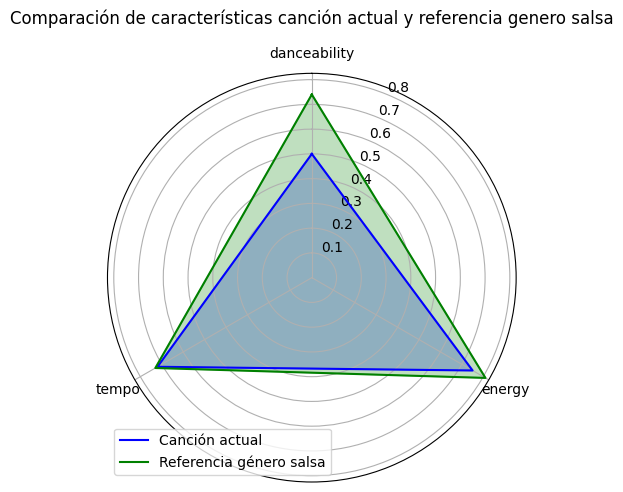

In [82]:
grafico_radar(features,valores_actuales,valores_referencia, nueva_cancion['genre'])